In [1]:
import yaml

In [2]:
with open("LAB.yaml", "r") as f:
    LAB_CONFIG = yaml.safe_load(f)

In [3]:
import torch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from torch import nn

In [6]:
class Encoder(nn.Module):

    def __init__(self, n_signals: int, n_features: int = 2):
        super(Encoder, self).__init__()

        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(n_signals, 512),
                                nn.ReLU(),
                                nn.Linear(512, 256),
                                nn.ReLU(),
                                nn.Linear(256, 128),
                                nn.ReLU(),
                                nn.Linear(128, n_features))

    def forward(self, X: torch.Tensor):
        out = self.fc(X)
        return out

In [7]:
class Decoder(nn.Module):

    def __init__(self, n_signals: int, n_features: int = 2):
        super(Decoder, self).__init__()

        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(n_features, 128),
                                nn.ReLU(),
                                nn.Linear(128, 256),
                                nn.ReLU(),
                                nn.Linear(256, 512),
                                nn.ReLU(),
                                nn.Linear(512, n_signals),
                                nn.ReLU())

    def forward(self, X: torch.Tensor):
        out = self.fc(X)
        return out

In [8]:
class Autoencoder(nn.Module):

    def __init__(self, n_signals: int, n_features: int = 2):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(n_signals=n_signals, n_features=n_features)
        self.decoder = Decoder(n_signals=n_signals, n_features=n_features)

    def forward(self, X: torch.Tensor):
        out = self.encoder(X)
        out = self.decoder(out)
        return out

In [9]:
class Classifier(nn.Module):

    def __init__(self, n_features: int, n_labels: int):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(n_features, n_labels))

    def forward(self, X: torch.Tensor):
        out = self.fc(X)
        return out

In [10]:
DATASET = "FashionMNIST"

In [11]:
import commons

In [12]:
commons.reproducibility.ensure(lab_config=LAB_CONFIG)

In [13]:
train_data = commons.data.load(lab_config=LAB_CONFIG,
                               dataset_name=DATASET,
                               train=True)

In [14]:
test_data = commons.data.load(lab_config=LAB_CONFIG,
                              dataset_name=DATASET,
                              train=False)

In [15]:
from torch.utils.data import DataLoader

In [16]:
train_dataloader = DataLoader(train_data, batch_size=64)

In [17]:
test_dataloader = DataLoader(test_data, batch_size=64)

In [18]:
dataset_description = commons.data.info(dataset_name=DATASET)

In [19]:
print(f"Name: {DATASET}",
      f"Input Shape (C, H, W): ({dataset_description['C']}, {dataset_description['H']}, {dataset_description['W']})",
      f"# Classes: {dataset_description['L']}", sep='\n')

Name: FashionMNIST
Input Shape (C, H, W): (1, 28, 28)
# Classes: 10


In [20]:
C, H, W, L = dataset_description['C'], dataset_description['H'], dataset_description['W'], dataset_description['L']
n_signals = C * H * W
n_features = 32

In [21]:
def autoencoder_train(autoencoder: nn.Module,
                      dataloader,
                      criterion: nn.Module,
                      optimizer: torch.optim.Optimizer):
    autoencoder.train()

    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        optimizer.zero_grad()

        X_hat: torch.tensor = autoencoder(X)

        loss = criterion(torch.reshape(X_hat, X.size()), X)
    
        loss.backward()

        optimizer.step()

        if batch % 300 == 0:
            print(f"Loss: {loss.item():>7f}",
                  "-",
                  f"[{(batch + 1) * len(X):>5d}/{len(dataloader.dataset):>5d}]")

In [22]:
def autoencoder_test(autoencoder: nn.Module, dataloader, criterion: nn.Module):
    autoencoder.eval()

    loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)

            X_hat: torch.tensor = autoencoder(X)
    
            loss = loss + criterion(torch.reshape(X_hat, X.size()), X).item()

    return loss / len(dataloader.dataset)

In [23]:
AUTOENCODER_N_EPOCHS = 50

In [24]:
autoencoder = Autoencoder(n_signals=n_signals, n_features=n_features)
autoencoder_criterion = nn.MSELoss()

autoencoder_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [25]:
print(autoencoder)
print(f"# Parameters: {commons.models.num_trainable_parameters(autoencoder)}")

Autoencoder(
  (encoder): Encoder(
    (fc): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): ReLU()
      (5): Linear(in_features=256, out_features=128, bias=True)
      (6): ReLU()
      (7): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (fc): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=32, out_features=128, bias=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=256, bias=True)
      (4): ReLU()
      (5): Linear(in_features=256, out_features=512, bias=True)
      (6): ReLU()
      (7): Linear(in_features=512, out_features=784, bias=True)
      (8): ReLU()
    )
  )
)
# Parameters: 1141296


In [26]:
for t in range(AUTOENCODER_N_EPOCHS):
    print(f"Epoch {t + 1}")

    autoencoder_train(autoencoder=autoencoder,
                      criterion=autoencoder_criterion,
                      optimizer=autoencoder_optimizer,
                      dataloader=train_dataloader)

    avg_loss = autoencoder_test(autoencoder=autoencoder,
                                criterion=autoencoder_criterion,
                                dataloader=test_dataloader)

    print(f"Test Error:",
          f"\tAvg. Loss: {avg_loss:>8f}", sep='\n')

Epoch 1
Loss: 0.202282 - [   64/60000]
Loss: 0.040037 - [19264/60000]
Loss: 0.030349 - [38464/60000]
Loss: 0.026822 - [57664/60000]
Test Error:
	Avg. Loss: 0.000423
Epoch 2
Loss: 0.026462 - [   64/60000]
Loss: 0.022980 - [19264/60000]
Loss: 0.023042 - [38464/60000]
Loss: 0.023160 - [57664/60000]
Test Error:
	Avg. Loss: 0.000364
Epoch 3
Loss: 0.022632 - [   64/60000]
Loss: 0.019891 - [19264/60000]
Loss: 0.020396 - [38464/60000]
Loss: 0.020860 - [57664/60000]
Test Error:
	Avg. Loss: 0.000333
Epoch 4
Loss: 0.020795 - [   64/60000]
Loss: 0.018450 - [19264/60000]
Loss: 0.019290 - [38464/60000]
Loss: 0.019526 - [57664/60000]
Test Error:
	Avg. Loss: 0.000304
Epoch 5
Loss: 0.018936 - [   64/60000]
Loss: 0.017134 - [19264/60000]
Loss: 0.017887 - [38464/60000]
Loss: 0.018330 - [57664/60000]
Test Error:
	Avg. Loss: 0.000284
Epoch 6
Loss: 0.017723 - [   64/60000]
Loss: 0.016196 - [19264/60000]
Loss: 0.017053 - [38464/60000]
Loss: 0.017707 - [57664/60000]
Test Error:
	Avg. Loss: 0.000271
Epoch 7
Lo

In [27]:
import numpy as np

In [28]:
N_EXAMPLES = 6

In [29]:
samples = np.random.randint(len(test_data), size=N_EXAMPLES)

In [30]:
import matplotlib.pyplot as plt

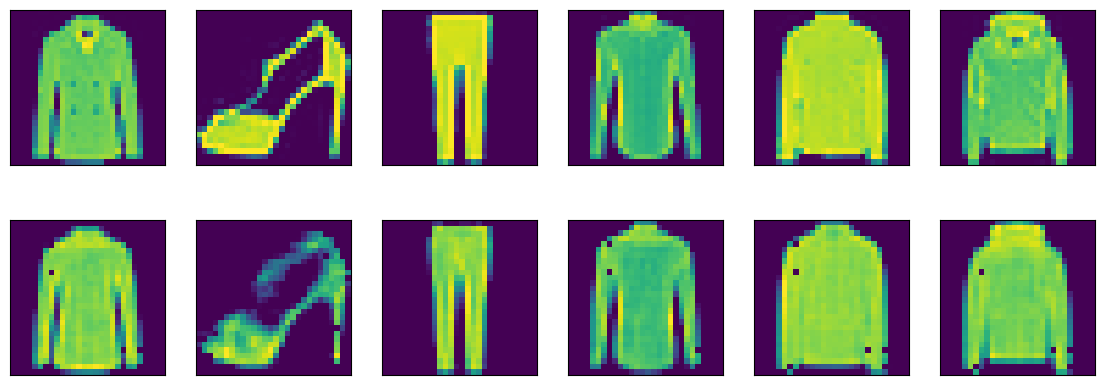

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=N_EXAMPLES, figsize=(14, 5))

with torch.no_grad():
    imgs = torch.cat([ test_data[idx][0] for idx in samples ], out=torch.Tensor(len(samples), W, H))
    imgs_reconstructed = autoencoder(imgs)
    
    for i in range(len(samples)):
        img = imgs[i].reshape(W, H, C)
        reconstruction = imgs_reconstructed[i].reshape(W, H, C)
    
        ax_img, ax_reconstruction = axes[0][i], axes[1][i]

        commons.plot.image(ax_img, img)
        commons.plot.image(ax_reconstruction, reconstruction)

In [32]:
def classifier_train(classifier: nn.Module, autoencoder: nn.Module,
                    dataloader,
                    criterion: nn.Module,
                    optimizer: torch.optim.Optimizer):
    autoencoder.eval()
    classifier.train()

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)

        optimizer.zero_grad()

        latent_space: torch.Tensor = autoencoder.encoder(X)
        y_hat: torch.Tensor = classifier(latent_space)

        loss = criterion(y_hat, y)
    
        loss.backward()

        optimizer.step()

        if batch % 300 == 0:
            print(f"Loss: {loss.item():>7f}",
                  "-",
                  f"[{(batch + 1) * len(X):>5d}/{len(dataloader.dataset):>5d}]")

In [33]:
def classifier_test(classifier: nn.Module, autoencoder: nn.Module, dataloader, criterion: nn.Module):
    autoencoder.eval()
    classifier.eval()

    loss, correct = 0.0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)

            latent_space: torch.Tensor = autoencoder.encoder(X)
            y_hat: torch.Tensor = classifier(latent_space)
    
            loss = loss + criterion(y_hat, y).item()
            correct = correct + (y_hat.argmax(1) == y).type(torch.float).sum().item()

    return loss / len(dataloader), 100.0 * (correct / len(dataloader.dataset))

In [34]:
classifier = Classifier(n_features=n_features, n_labels=L)
classifier_criterion = nn.CrossEntropyLoss()

classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

In [35]:
print(classifier)
print(f"# Parameters: {commons.models.num_trainable_parameters(classifier)}")

Classifier(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32, out_features=10, bias=True)
  )
)
# Parameters: 330


In [36]:
CLASSIFIER_N_EPOCHS = 50

In [37]:
for t in range(CLASSIFIER_N_EPOCHS):
    print(f"Epoch {t + 1}")

    classifier_train(classifier=classifier, autoencoder=autoencoder,
                    dataloader=train_dataloader,
                    criterion=classifier_criterion, optimizer=classifier_optimizer)

    _, accuracy = classifier_test(classifier=classifier,
                                 autoencoder=autoencoder,
                                 criterion=classifier_criterion,
                                 dataloader=test_dataloader)

    print(f"Test Error:",
          f"\tAccuracy: {accuracy}", sep='\n')

Epoch 1
Loss: 2.372582 - [   64/60000]
Loss: 1.496196 - [19264/60000]
Loss: 1.073053 - [38464/60000]
Loss: 0.834345 - [57664/60000]
Test Error:
	Accuracy: 76.61
Epoch 2
Loss: 0.799873 - [   64/60000]
Loss: 0.885855 - [19264/60000]
Loss: 0.762614 - [38464/60000]
Loss: 0.628013 - [57664/60000]
Test Error:
	Accuracy: 79.13
Epoch 3
Loss: 0.579277 - [   64/60000]
Loss: 0.750270 - [19264/60000]
Loss: 0.672183 - [38464/60000]
Loss: 0.545994 - [57664/60000]
Test Error:
	Accuracy: 80.21000000000001
Epoch 4
Loss: 0.494357 - [   64/60000]
Loss: 0.691854 - [19264/60000]
Loss: 0.626560 - [38464/60000]
Loss: 0.502534 - [57664/60000]
Test Error:
	Accuracy: 80.61
Epoch 5
Loss: 0.448369 - [   64/60000]
Loss: 0.661088 - [19264/60000]
Loss: 0.597938 - [38464/60000]
Loss: 0.476868 - [57664/60000]
Test Error:
	Accuracy: 80.87
Epoch 6
Loss: 0.419788 - [   64/60000]
Loss: 0.643029 - [19264/60000]
Loss: 0.578050 - [38464/60000]
Loss: 0.460595 - [57664/60000]
Test Error:
	Accuracy: 81.07
Epoch 7
Loss: 0.400649

In [38]:
label_to_class = { key: value for value, key in test_data.class_to_idx.items() }

class_names = np.array(list(label_to_class.values()))

for label, name in label_to_class.items():
    print(f"{label}: {name}")

0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


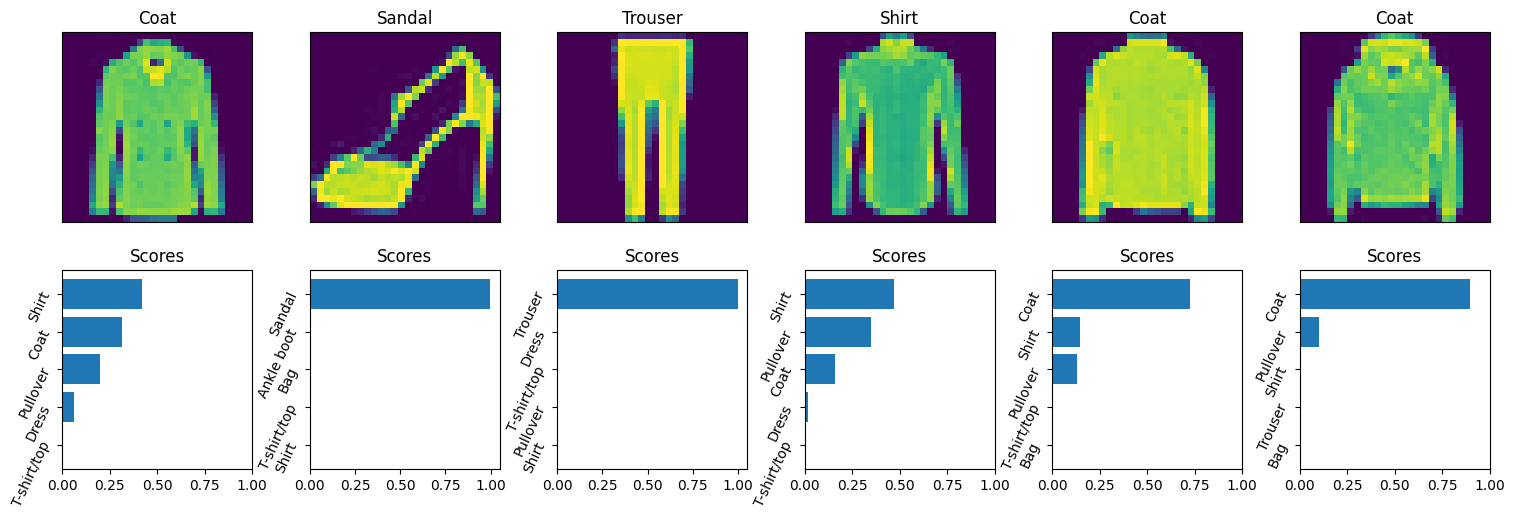

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=N_EXAMPLES, figsize=(15, 5))

fig.tight_layout()

with torch.no_grad():
    X = torch.cat([ test_data[idx][0] for idx in samples ], out=torch.Tensor(len(samples), W, H))
    y = torch.Tensor([ test_data[idx][1] for idx in samples ])

    y_hat = nn.functional.softmax(classifier(autoencoder.encoder(imgs)), dim=1)

    for i, (img, correct, prediction) in enumerate(zip(X, y, y_hat)):
        labels, indices = torch.sort(prediction)
    
        labels = labels[-5:]
    
        ax_img, ax_classification = axes[0][i], axes[1][i]

        ax_img.set_title(label_to_class[int(correct)])
        commons.plot.image(ax_img, img.reshape(W, H, C))

        ax_classification.set_title("Scores")
        commons.plot.classification_scores(ax_classification, class_names[indices][-5:], labels)

In [40]:
_ = torch.set_grad_enabled(False)

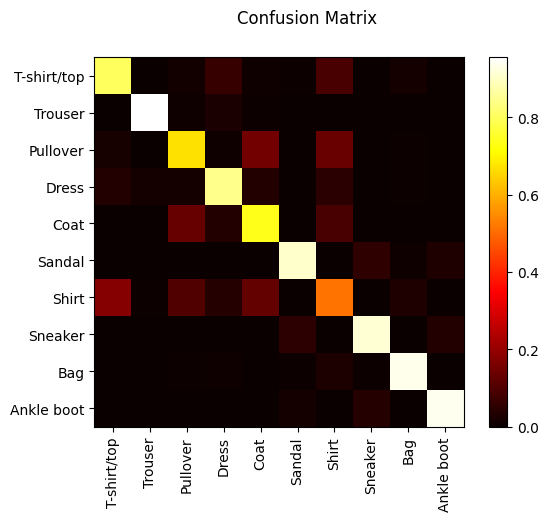

In [41]:
y, y_hat = list(), list()

for X, Y in test_dataloader:
        y_hat.extend(classifier(autoencoder.encoder(X)).argmax(1).numpy())
        y.extend(Y.numpy())

commons.plot.confusion_matrix(y, y_hat, class_names)

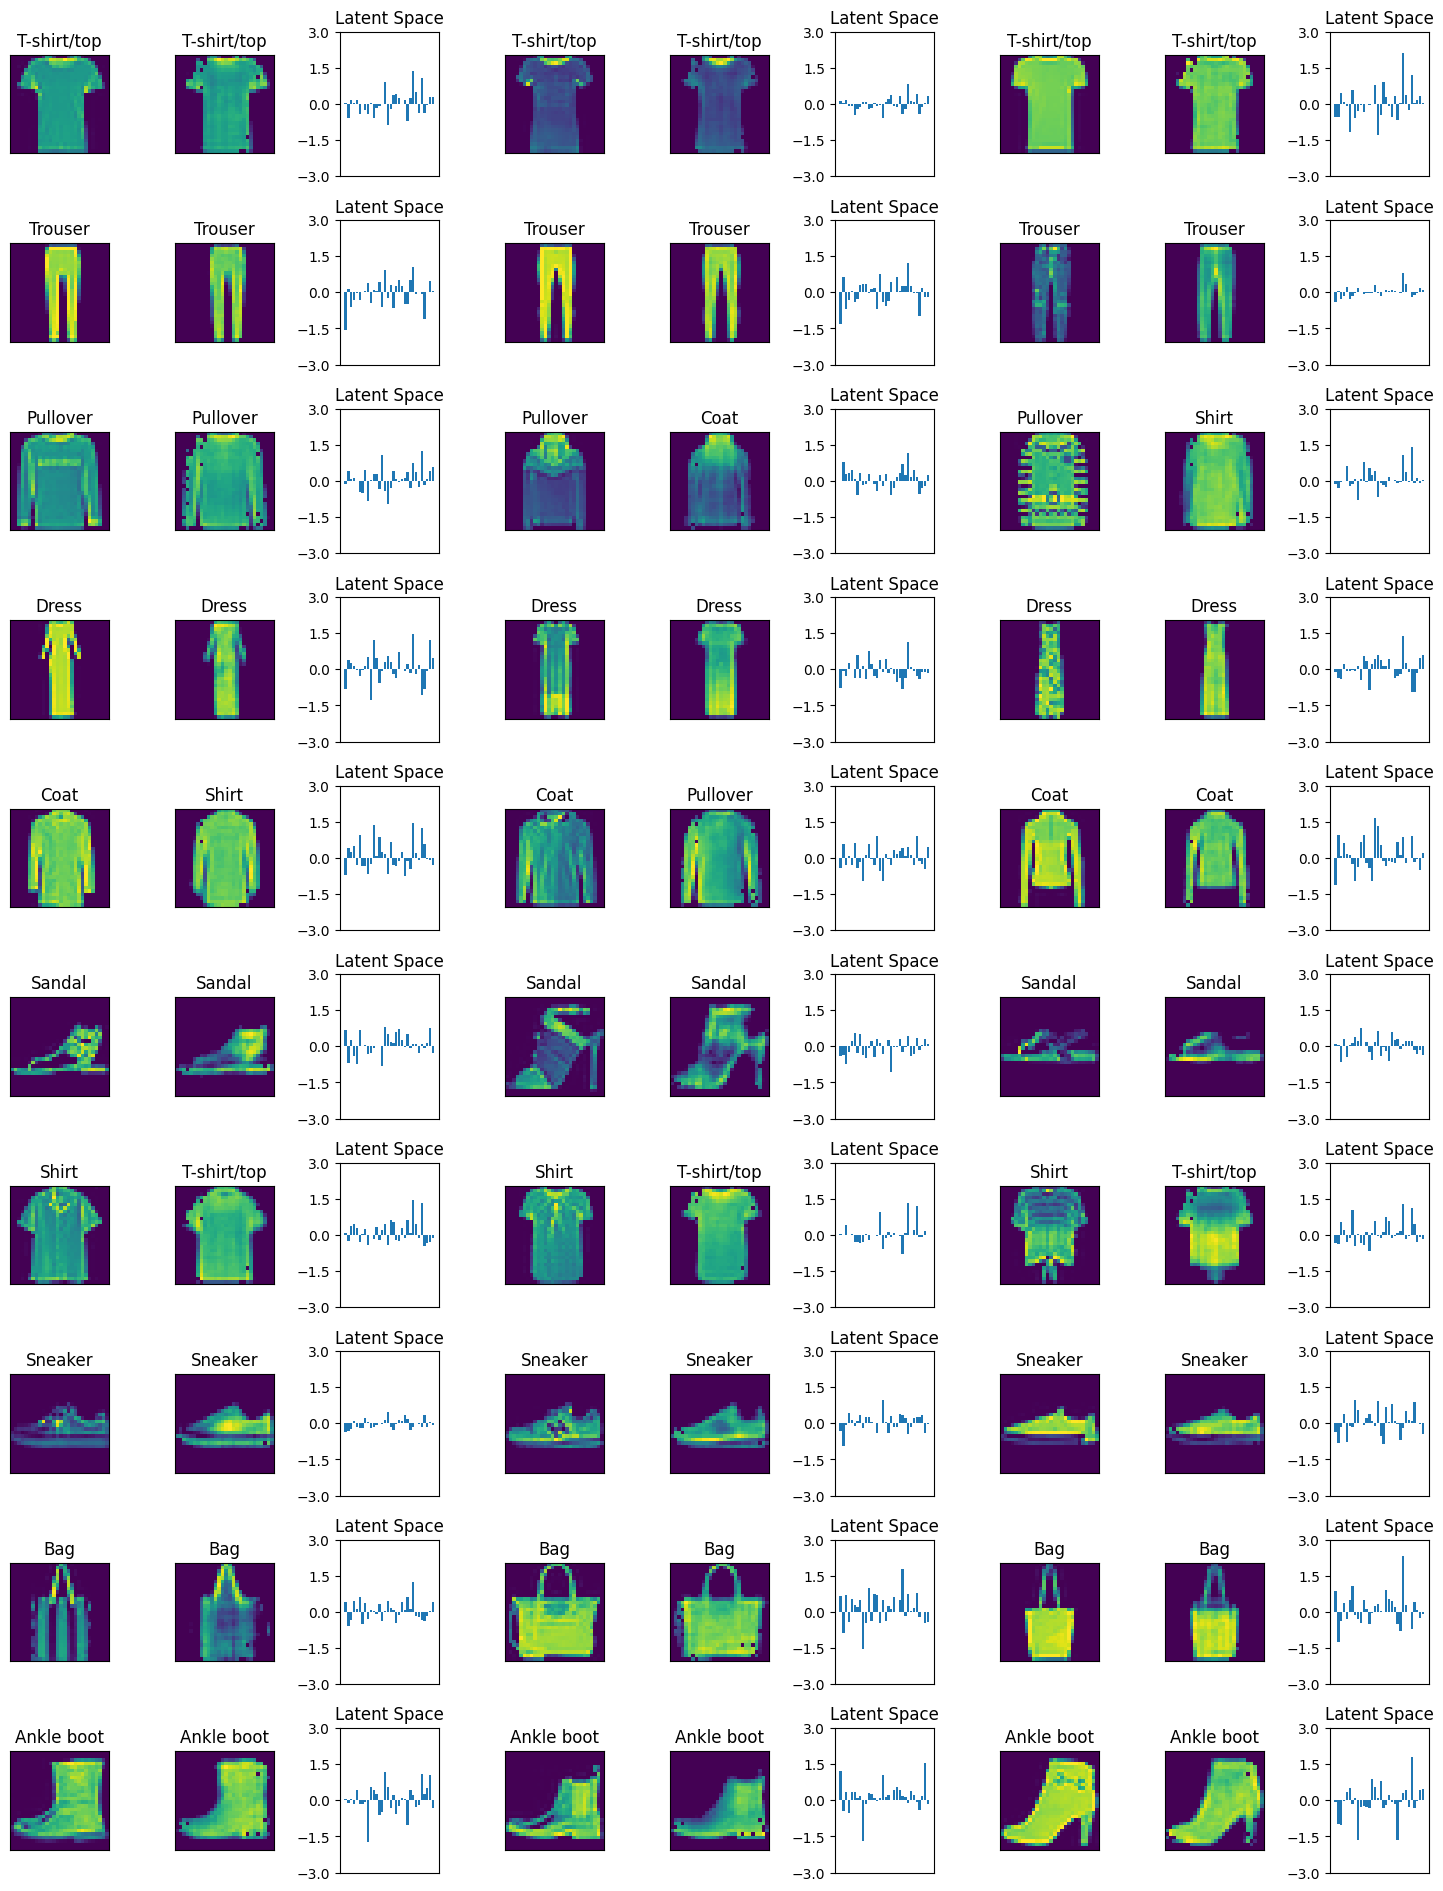

In [48]:
N_EXAMPLES_PER_CLASS = 3

targets = np.array(train_data.targets)

fig, axis = plt.subplots(nrows=L, ncols=3 * N_EXAMPLES_PER_CLASS, figsize=(15, 20))

fig.tight_layout(rect=[ 0.0, 0.0, 1, 0.95 ])

for i in label_to_class.keys():
    target_idx = np.argwhere(targets == i).flatten()
    
    sampler = torch.utils.data.sampler.SubsetRandomSampler(np.random.choice(target_idx, N_EXAMPLES_PER_CLASS))

    loader = DataLoader(train_data, sampler=sampler)
    
    for j, (X, y) in enumerate(loader):
        latent_space = autoencoder.encoder(X)
        reconstruction = autoencoder.decoder(latent_space).reshape(H, W)
        classification = classifier(latent_space).argmax(1)

        ax_img, ax_reconstruction, ax_latent_space = axis[i][3 * j: 3 * j + 3]

        ax_img.set_title(f"{class_names[y.item()]}")
        commons.plot.image(ax_img, X.reshape(H, W))

        ax_reconstruction.set_title(f"{class_names[classification.item()]}")
        commons.plot.image(ax_reconstruction, reconstruction)
        
        ax_latent_space.set_title("Latent Space")
        commons.plot.latent_space(ax_latent_space, latent_space[0], normalize=False)
        ax_latent_space.set_yticks(np.linspace(-3, 3, 5))

In [43]:
import collections

In [44]:
correct_representation_per_label = collections.defaultdict(list)

for i, (X, y) in enumerate(test_dataloader):
    X = X.to(device)

    latent_space: torch.Tensor = autoencoder.encoder(X)
    y_hat: torch.Tensor = classifier(latent_space)

    indices = torch.argwhere(y_hat.argmax(1) == y)

    for i in indices:
        label = int(y[int(i.item())])
        correct_representation_per_label[label].append(latent_space[i].flatten())

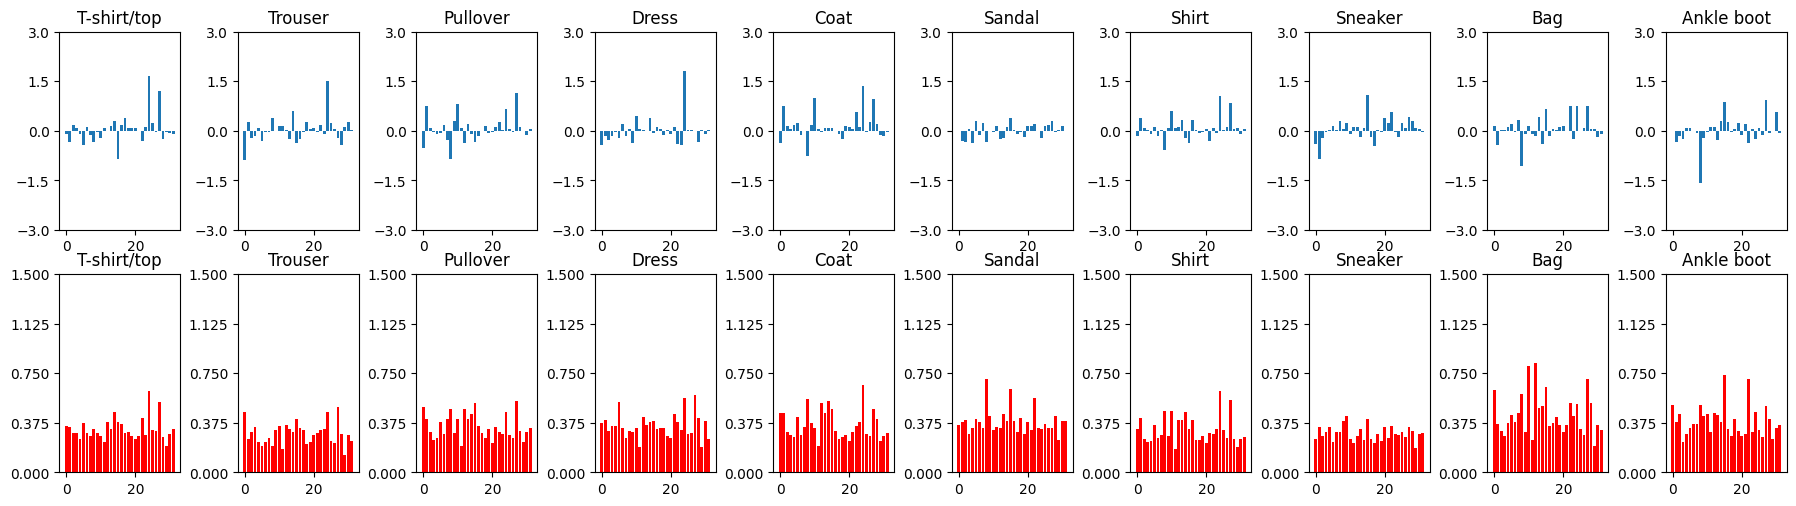

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=L, figsize=(18, 5))

fig.tight_layout()

for k, v in correct_representation_per_label.items():
    correct_representations = torch.stack(v)

    mx_value = torch.max(correct_representations)
    mn_value = torch.min(correct_representations)

    sigma, mu = torch.std_mean(correct_representations, dim=0)

    axes[0][k].set_title(label_to_class[k])
    axes[0][k].bar(range(len(mu)), mu)
    axes[0][k].set_yticks(np.linspace(-3, 3, 5))

    axes[1][k].set_title(label_to_class[k])
    axes[1][k].bar(range(len(sigma)), sigma, color='red')
    axes[1][k].set_yticks(np.linspace(0, 1.5, 5))